In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.cosmology import z_at_value

from bornraytrace import intrinsic_alignments as ia
from bornraytrace import lensing
from matplotlib import rcParams
rcParams.update({'font.size':16})

In [2]:
def recentre_nz(z_sim_edges, z_samp_centre, nz_input):
    nz_input = np.interp(z_sim_edges[1:],z_samp_centre, nz_input) 
    return nz_input/np.sum(nz_input*(z_sim_edges[1:]-z_sim_edges[:-1]))

# Load simulation

In [3]:
cosmo_taka = FlatLambdaCDM(H0= 70 * u.km / u.s / u.Mpc, Om0=(0.233+0.046))

In [4]:
nside = 512
overdensity_array = np.load('example_data/takahashi_overdensity_array.npy')
z_bin_edges = np.genfromtxt('example_data/z.txt')

In [5]:
comoving_edges =  cosmo_taka.comoving_distance(z_bin_edges)
z_centre = np.array([z_at_value(cosmo_taka.comoving_distance, 0.5*(comoving_edges[i]+comoving_edges[i+1])) \
                     for i in range(len(comoving_edges)-1)])

# Calculate lensing $\kappa(z)$ maps

In [6]:
kappa_lensing = np.copy(overdensity_array)*0.

for i in np.arange(1,kappa_lensing.shape[0]+1):
    kappa_lensing[i-1] = lensing.raytrace(cosmo_taka.H0, cosmo_taka.Om0,
                                     overdensity_array=overdensity_array[:i].T,
                                     a_centre=1./(1.+z_centre[:i]),
                                     comoving_edges=comoving_edges[:(i+1)])

# Calculate IA $\kappa(z)$ maps ($A_{IA}  = 0.49$)

In [7]:
c1 = (5e-14 * (u.Mpc**3.)/(u.solMass * u.littleh**2) ) 
c1_cgs = (c1* ((u.littleh/(cosmo_taka.H0.value/100))**2.)).cgs
rho_c1 = (c1_cgs*cosmo_taka.critical_density(0)).value
print(c1,'\n',rho_c1)
f_nla_array = ia.F_nla(z_centre, cosmo_taka.Om0, A_ia=0.49, rho_c1=(c1_cgs*cosmo_taka.critical_density(0)).value)

5e-14 Mpc3 / (littleh2 solMass) 
 0.01387683136229154


In [8]:
kappa_ia_array =  (overdensity_array.T * f_nla_array).T

# Integrate over $n(z)$

In [9]:
nz_mean = np.load('/global/cscratch1/sd/alexalar/desy3data/Nz_samples/v0.50/3sdir_fid_zsamplefid/nz_samples.npy').mean(axis=0)
z_samp_centre = np.load('/global/cscratch1/sd/alexalar/desy3data/Nz_samples/sv_sn_test1/bin_centers.npy')
nz_recentred = recentre_nz(z_bin_edges, z_samp_centre, nz_mean[1])
print(np.trapz(nz_recentred,z_centre))

0.9932249980841783


In [10]:
nz_kernel = nz_recentred*(z_bin_edges[1:]-z_bin_edges[:-1])
kappa_ia_nz = np.sum(nz_kernel*kappa_ia_array.T,axis=1)
kappa_lensing_nz = np.sum(nz_kernel*kappa_lensing.T,axis=1)

/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


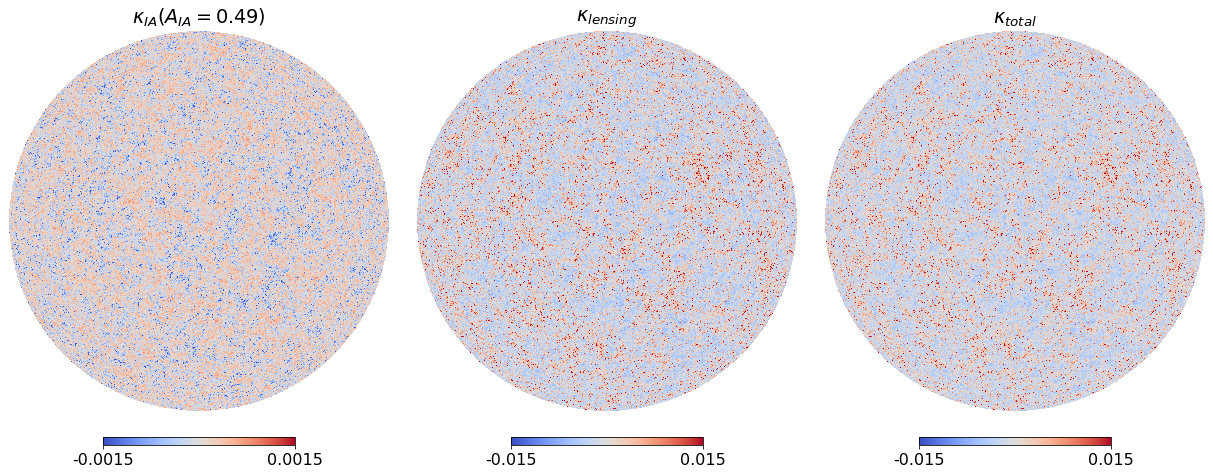

In [11]:
plt.figure(figsize=(17,7));
hp.orthview(kappa_ia_nz, cmap='coolwarm', rot=(45,30), xsize=1000,
            min=-0.0015, max=0.0015 , sub=(1,3,1), half_sky=True, title=r'$\kappa_{IA} (A_{IA} = 0.49)$');
hp.orthview(kappa_lensing_nz, cmap='coolwarm', rot=(45,30),
            min=-0.015, max=0.015 , sub=(1,3,2), half_sky=True, title=r'$\kappa_{lensing}$');
hp.orthview(kappa_lensing_nz+kappa_ia_nz, cmap='coolwarm', rot=(45,30),
            min=-0.015, max=0.015 , sub=(1,3,3), half_sky=True, title=r'$\kappa_{total}$');

# Compare power

In [12]:
power_total = hp.anafast(kappa_lensing_nz+kappa_ia_nz, lmax=nside*2)
power_lensing = hp.anafast(kappa_lensing_nz, lmax=nside*2)
power_ia = hp.anafast(kappa_ia_nz, lmax=nside*2)
ell = np.arange(len(power_total))

In [13]:
pyccl_corrected_theory = np.load('example_data/pyccl_corrected_nz_prediction.npy')
ell_pyccl, pyccl_corrected_theory = pyccl_corrected_theory[0], pyccl_corrected_theory[1]

In [14]:
lensing_power_cosmosis_ia = np.load('example_data/cosmosis_ia_prediction.npy')
ell_cosmosis, lensing_power_cosmosis_ia = lensing_power_cosmosis_ia[0], lensing_power_cosmosis_ia[1]

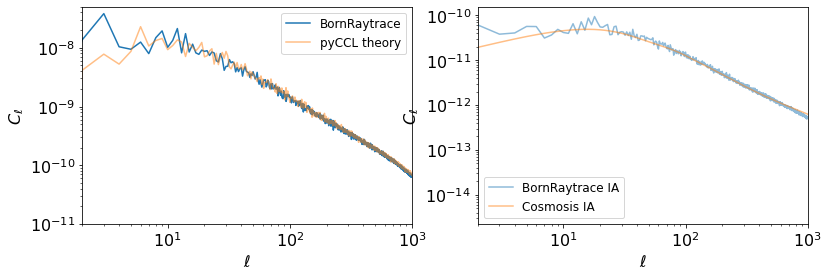

In [21]:
_ = plt.figure(figsize=(13,4)), plt.subplot(1,2,1)
_ = plt.plot(ell, power_lensing,label='BornRaytrace')
_ = plt.loglog(ell_pyccl,pyccl_corrected_theory,label= 'pyCCL theory', alpha=0.5)
_ = plt.legend(fontsize=12)
_ = plt.ylabel(r'$C_\ell$', fontsize=16)
_ = plt.xlabel(r'$\ell$', fontsize=16)
_ = plt.ylim(1e-11,5e-8)
_ = plt.xlim(2,1000)

_ = plt.subplot(1,2,2)
_ = plt.plot(ell, power_ia,label='BornRaytrace IA', alpha=0.5)
_ = plt.loglog(ell_cosmosis,lensing_power_cosmosis_ia,label= 'Cosmosis IA', alpha=0.5)
_ = plt.legend(fontsize=12)
_ = plt.legend(fontsize=12)
_ = plt.ylabel(r'$C_\ell$', fontsize=16)
_ = plt.xlabel(r'$\ell$', fontsize=16)
_ = plt.xlim(2,1000)
